# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [110]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

### The imports I added 
### I like my imports to be at one spot, easy to find
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.colors as mc
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.pipeline import make_pipeline

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [52]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [53]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [54]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()
df_offers.shape

(32, 7)

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [55]:
#your turn

### Merging the two dataframes
df=pd.merge(df_offers, df_transactions)

### Pivoting df to get customer_name and offer_id as columns
### pandas.pivot(index, columns, values)  based on 3 columns of the DataFrame.
### Uses unique values from index / columns and fills with values.
dfp=df.pivot(index = 'customer_name', columns = 'offer_id', values = 'n')
dfp.fillna(0, inplace = True)
df.shape

(324, 9)

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

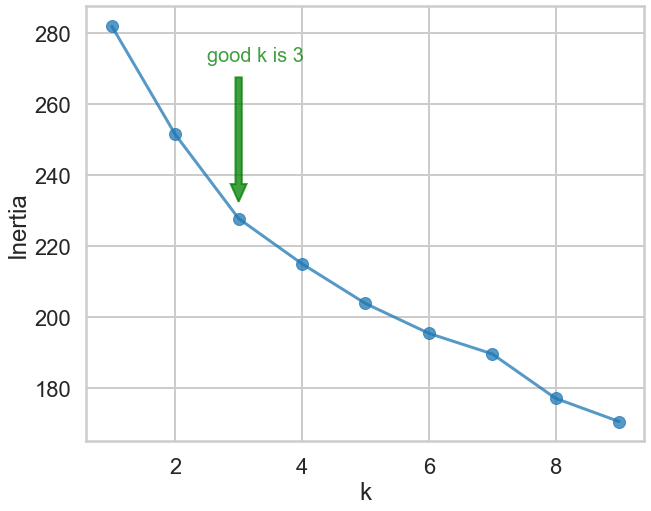

In [56]:
# your turn
### Let's find out which k I should use
### Getting the inertia from models using
### 1 to 10 k
ks = range(1,10)
dfp_inertias=[]
for k in ks:
    model= KMeans(n_clusters=k)
    model.fit(dfp)
    dfp_inertias.append(model.inertia_)

### Plottin the ks vs. inertia
fig= plt.figure(figsize=[10,8])
plt.plot(ks, dfp_inertias, marker = 'o', alpha=0.75)
plt.arrow(3,270,0,-30, color='green', width=0.1, head_starts_at_zero=True, head_length=5, head_width=0.25, shape='full', alpha=0.75, length_includes_head= False)
plt.annotate('good k is 3',(2.5,272), fontsize=20, color='green', alpha=0.75)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

The stepness of the slope gets milder after k=3. Therefore k=3 is the best choice.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [57]:
dfp.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
For n_clusters = 6 The average silhouette_score is : 0.11879508142787866


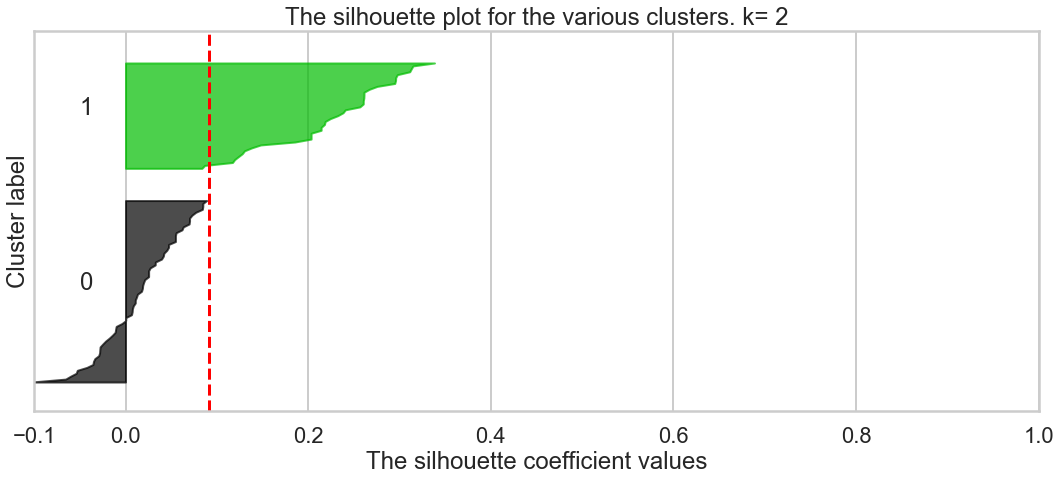

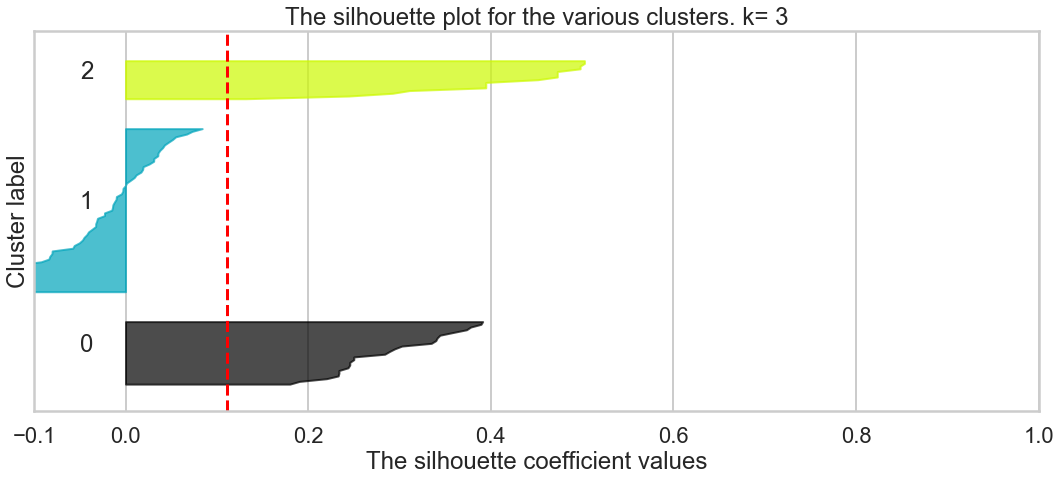

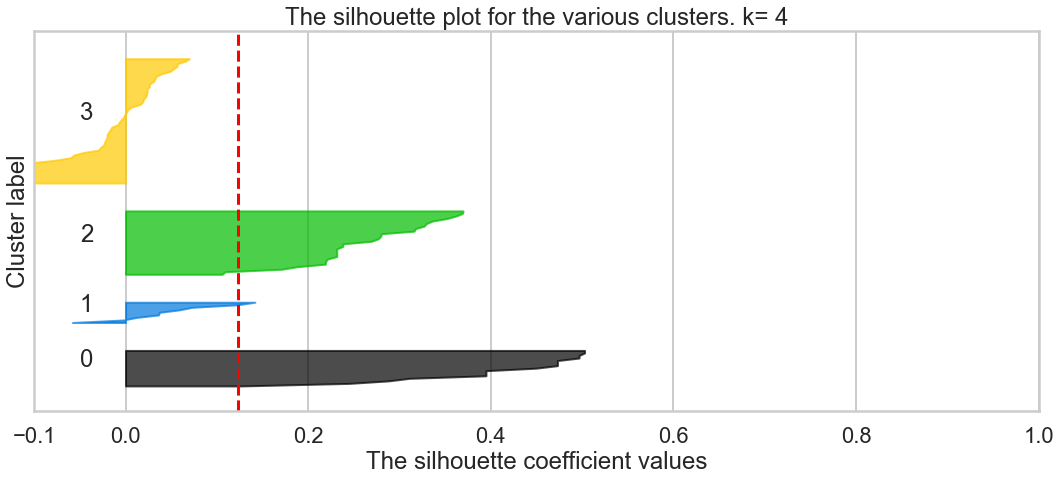

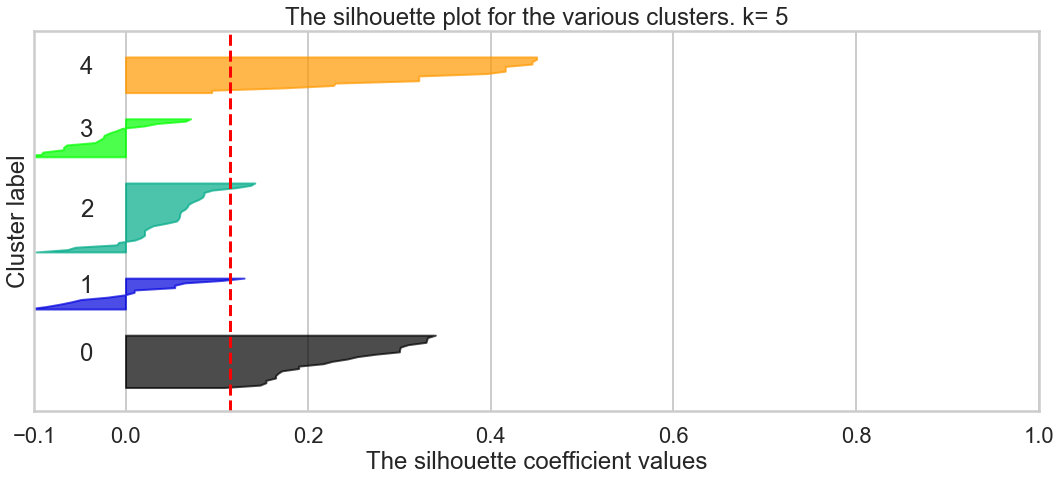

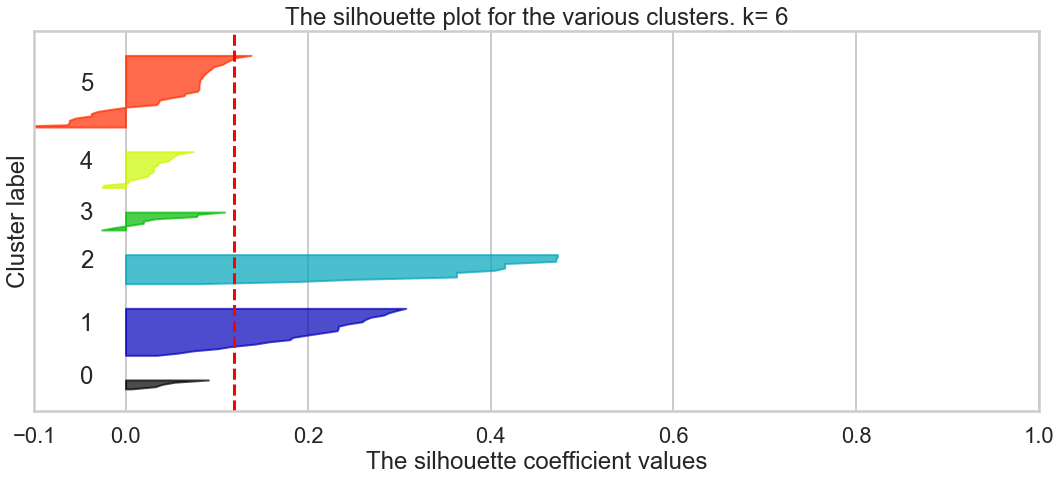

In [58]:
# Your turn.
### sklearn.metrics.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)


range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    ''' prepare the frame for the silhouette plot'''
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(dfp) + (n_clusters + 1) * 10])
    ''' initialize KMeans, then fit and predict on data dfp'''
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dfp)
    
    '''calculate the silhouette score for all the samples'''
    silhouette_avg = silhouette_score(dfp, cluster_labels)
    
    ''' calculate the silhouette score for each sample''' 
    sample_silhouette_values = silhouette_samples(dfp, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    y_lower = 10
    for i in range(n_clusters):
        '''Aggregate the silhouette scores for samples belonging to
        cluster i, and sort them'''
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        '''Label the silhouette plots with their cluster numbers at the middle'''
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        '''Compute the new y_lower for next plot '''
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters. k= {}".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ''' The vertical line for average silhouette score of all the values '''
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

The silhouette average is shown by the red dashed line. 
for k=2, cluster 0 looks as big as cluster 1, and it has a lot of data that are not clustered (i.e. negative values). CLuster 0 is under silhouette average.
for k=3, cluster 1 has a lot of negative values, though cluster 0 and 2 are well developed. 2 out of 4 clusters are under silhouette average. Cluster 1 is under silhouette average.
for k=4, cluster 0 and 2 are fine , cluster 1 got better, but there are a lot of unclustered values remaining in cluster 3
for k=5, cluster 0 and 4 are fine and the other clusters have a lot of negative values. 3 clusters out of 5 are under silhouette average.
for k=6, some of the "negative values" in lower ks are better clustered in clusters 3, 4 and 5, though some negative values remain. 4 cluster out of 6 are under silhouette average.

I don't choose k=4,5,6 because the majority of clusters are under silhouette average and there are a lot of negative values.

Between k=2 and k=3, I prefer the latter because of 2 out 3 silhouette are above average and these two silhouettes do not have negative values.

I'll go with k=3.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [59]:
#your turn

### Getting dfp in shape
dfp2= dfp.reset_index()
### Dropping the string column customer_name
### to satisfy the PCA
dfp3=dfp2.drop(columns='customer_name')
dfp3.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


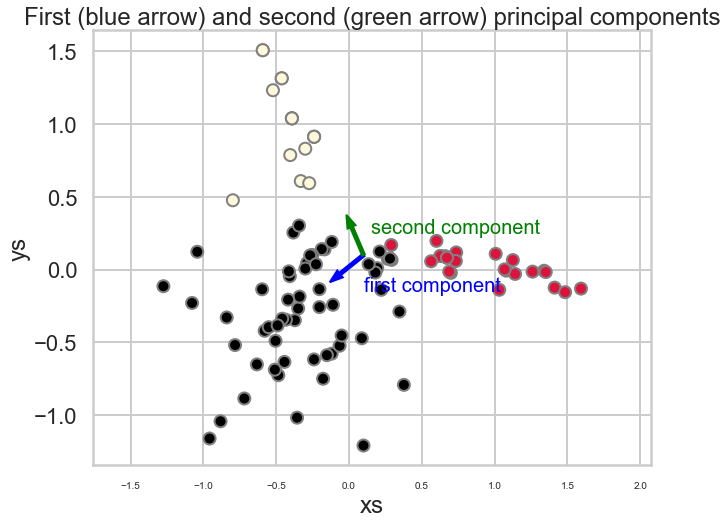

In [74]:
### building again the kmeans clusters on dfp3
### this time using the chosen k=3
k3_model= KMeans(n_clusters=3)
k3_clusters= k3_model.fit_predict(dfp3)

### decorrelating k3_clusters using PCA 
pcamodel=PCA(n_components=2)
pca_features=pcamodel.fit_transform(dfp3)
xs=pca_features[:,0]
ys=pca_features[:,1]


### Getting first and second components
first_pc= pcamodel.components_[0,:]
second_pc= pcamodel.components_[1,:]

### Getting the mean of the model
mean=pcamodel.mean_

### Plotting decorrelation with
### 1st and 2nd components as arrows
fig= plt.figure(figsize=[10,8])
plt.title('First (blue arrow) and second (green arrow) principal components')
plt.xlabel('xs')
plt.ylabel('ys')
bcc= mc.ListedColormap(['black','crimson','cornsilk'])
plt.scatter(xs, ys, c=k3_clusters.tolist(), cmap=bcc, edgecolor='grey')
plt.axis('equal')
plt.arrow(mean[0], mean[1], first_pc[0], first_pc[1], color='blue', width= 0.02)
plt.arrow(mean[0], mean[1], second_pc[0], second_pc[1], color='green', width= 0.02)
plt.annotate('first component',(0.1,-0.15), fontsize=20, color='blue')
plt.annotate('second component',(0.15,0.25), fontsize=20, color='green')
plt.show()

Note that the color of the clusters vary each time I run the code. On this graph the black cluster is supposed to be the largest cluster which expands from the mean towards -1. The crimson group is the one to the right of the black cluster. The cream cluster is the top one.
I am fine with k=3. The crimson and black clusters seem close but they are relatively well separated from each other and from the cream cluster by PCA. I can see now why it was difficult to pick k from the silhouette score results and why there was so many negative/unclustered values in most silhouettes. 

Now I am suppposed to look at both the original raw data about the offers and transactions and look at the fitted clusters and to tell a story about it. I first need to create a dataframe containing the original data from df and the clusters_id. Then I'll plot the data to find out about what the clusters tell us. The transactional data shows which offer customers responded to, and what the customer ended up buying.

In [75]:
### Getting cluster_id in dfp2
dfp2['cluster_id']=k3_clusters
dfp2.reset_index()

### Subsetting to get rid of all the offer_id columns in cluster_table
cluster_table=dfp2[['customer_name', 'cluster_id']]

### Merging original data from df to cluster_table
### to make clusterstory
ct=pd.merge(df, cluster_table, on= ['customer_name'], how='left')

### Splitting the dataframe by clusters
zero= ct.loc[ct.cluster_id == 0]
one= ct.loc[ct.cluster_id == 1]
two= ct.loc[ct.cluster_id == 2]
zero.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster_id
0,1,January,Malbec,72,56,France,False,Thomas,1,0
1,1,January,Malbec,72,56,France,False,Jackson,1,0
2,1,January,Malbec,72,56,France,False,Mitchell,1,0
4,1,January,Malbec,72,56,France,False,Wood,1,0
5,1,January,Malbec,72,56,France,False,Price,1,0


In [76]:
zero_1=zero.groupby(by=['offer_id','varietal']).count().reset_index()
one_1=one.groupby(by=['offer_id','varietal']).count().reset_index()
two_1=two.groupby(by=['offer_id','varietal']).count().reset_index()

zero_1.head()

,offer_id,varietal,campaign,min_qty,discount,origin,past_peak,customer_name,n,cluster_id
0,1,Malbec,9,9,9,9,9,9,9,9
1,2,Pinot Noir,4,4,4,4,4,4,4,4
2,3,Espumante,6,6,6,6,6,6,6,6
3,4,Champagne,12,12,12,12,12,12,12,12
4,5,Cabernet Sauvignon,4,4,4,4,4,4,4,4


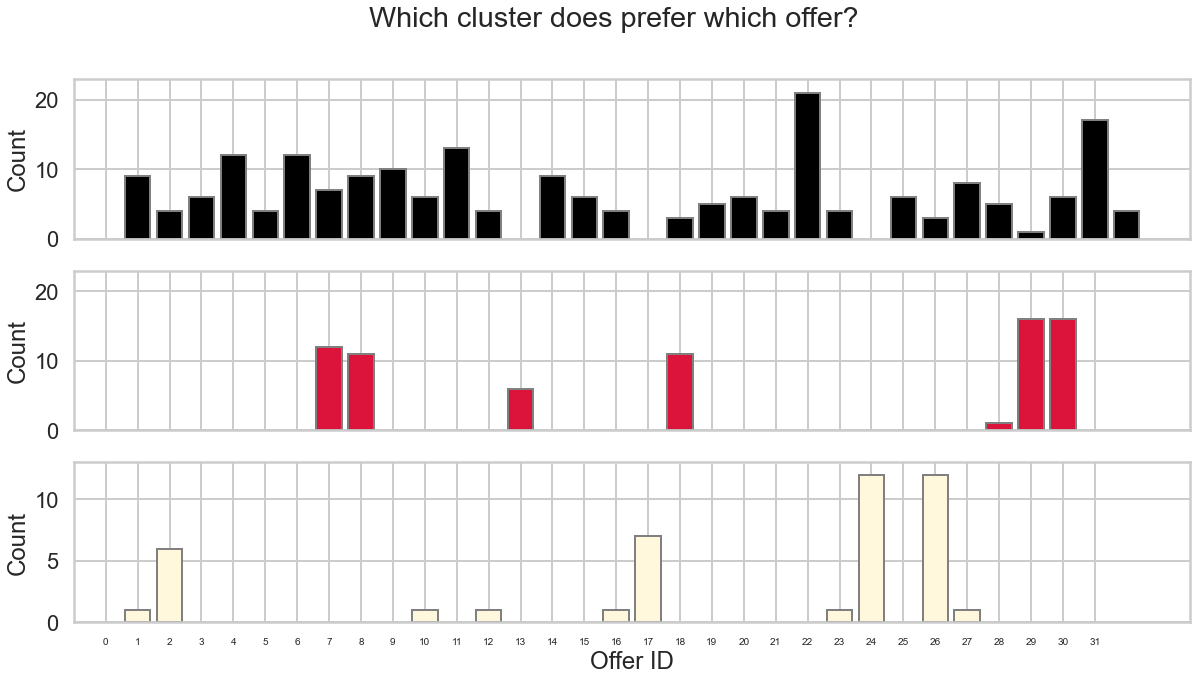

In [80]:
fig, ax = plt.subplots(3,  figsize=[20,10], sharex=True)
plt.suptitle('Which cluster does prefer which offer?')
ax[0].bar(zero_1.offer_id, zero_1.cluster_id, color='black', edgecolor='grey')
ax[1].bar(one_1.offer_id, one_1.cluster_id, color='crimson', edgecolor='grey')
ax[2].bar(two_1.offer_id, two_1.cluster_id, color='cornsilk', edgecolor='grey')
plt.xticks(np.arange(0, 32, step=1))
plt.xlabel('Offer ID')
ax[0].set(ylabel='Count')
ax[1].set(ylabel='Count')
ax[2].set(ylabel='Count')
ax[0].set_ylim([0,23])
ax[1].set_ylim([0,23])
ax[2].set_ylim([0,13])

plt.show()

The black cluster was the one that showed the most variance in the plot of PCA features. Unsurpisingly, it is the cluster of customers that went along with the largest range of offers/wine varieties. For the crimson and cream  clusters, the customers were interest in more specific offers.
Is it time related (i.e. january vs. september)? Is it related to the type of wine? or the origin?

In [88]:
zero_2=zero.groupby(by=['campaign']).count().reset_index()
one_2=one.groupby(by=['campaign']).count().reset_index()
two_2=two.groupby(by=['campaign']).count().reset_index()


zero_2['months'] = pd.to_datetime(zero_2['campaign'], format='%B').dt.month
one_2['months'] = pd.to_datetime(one_2['campaign'], format='%B').dt.month
two_2['months'] = pd.to_datetime(two_2['campaign'], format='%B').dt.month
zero_2

,campaign,offer_id,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster_id,months
0,April,16,16,16,16,16,16,16,16,16,4
1,August,31,31,31,31,31,31,31,31,31,8
2,December,27,27,27,27,27,27,27,27,27,12
3,February,22,22,22,22,22,22,22,22,22,2
4,January,13,13,13,13,13,13,13,13,13,1
5,July,8,8,8,8,8,8,8,8,8,7
6,June,19,19,19,19,19,19,19,19,19,6
7,March,28,28,28,28,28,28,28,28,28,3
8,May,17,17,17,17,17,17,17,17,17,5
9,November,6,6,6,6,6,6,6,6,6,11


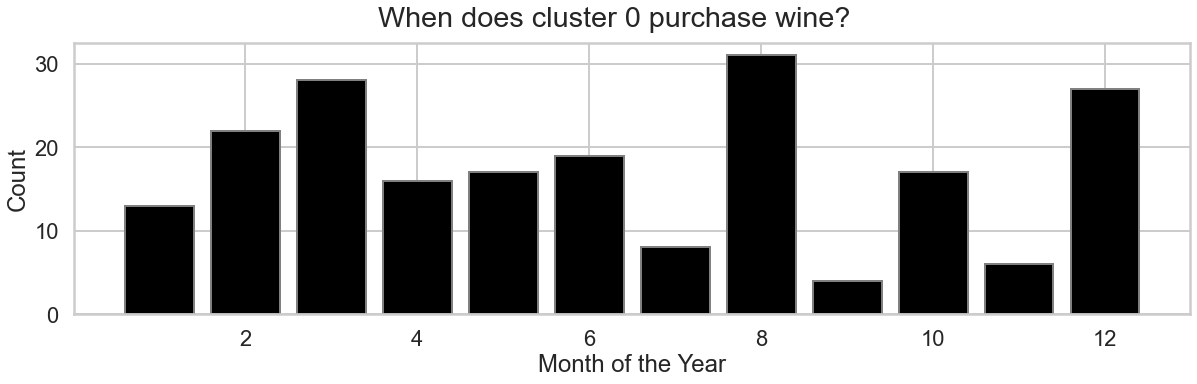

In [95]:
plt.subplots(figsize=[20,5])
plt.suptitle('When does cluster 0 purchase wine?')
plt.bar(zero_2.months, zero_2.cluster_id, color='black', edgecolor='grey')
plt.xlabel('Month of the Year')
plt.ylabel('Count')

plt.show()

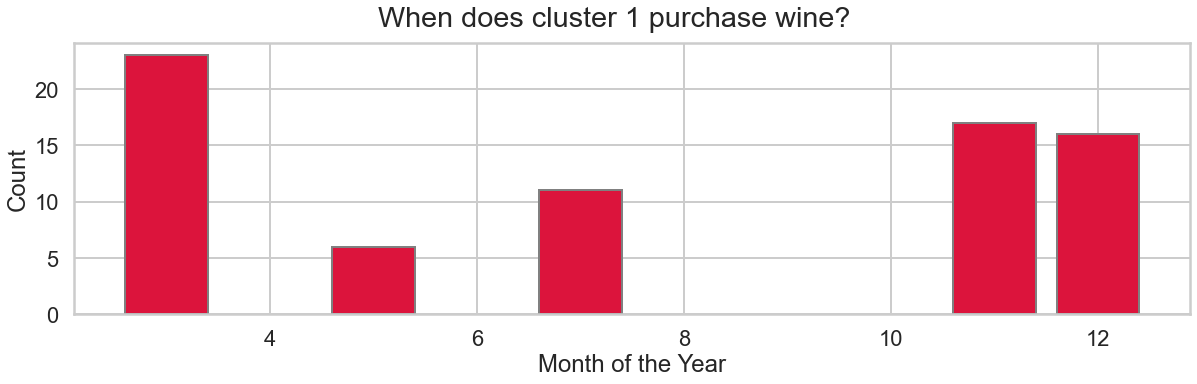

In [97]:
plt.subplots(figsize=[20,5])
plt.suptitle('When does cluster 1 purchase wine?')
plt.bar(one_2.months, one_2.cluster_id, color='crimson', edgecolor='grey')
plt.xlabel('Month of the Year')
plt.ylabel('Count')

plt.show()

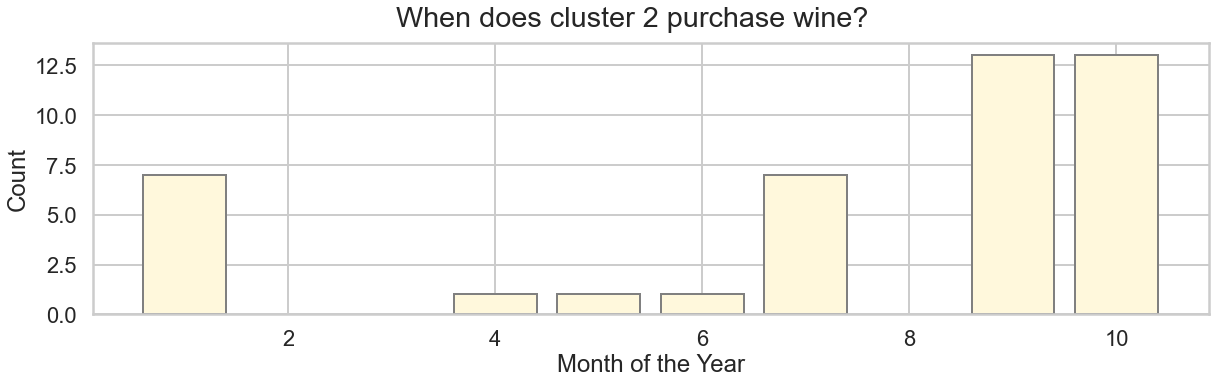

In [94]:
plt.subplots(figsize=[20,5])
plt.suptitle('When does cluster 2 purchase wine?')
plt.bar(two_2.months, two_2.cluster_id, color='cornsilk', edgecolor='grey')
plt.xlabel('Month of the Year')
plt.ylabel('Count')

plt.show()

The customers from cluster 1 (crimson) bought wine mainly in March and at the end of the year. By contrast, the customers from cluster (cream) bought wine mainly in September, October, January and July. Unsurprisingly, the customers from cluster 0 (black) bought wine at any time of the year with a prevalence in March, August and December.

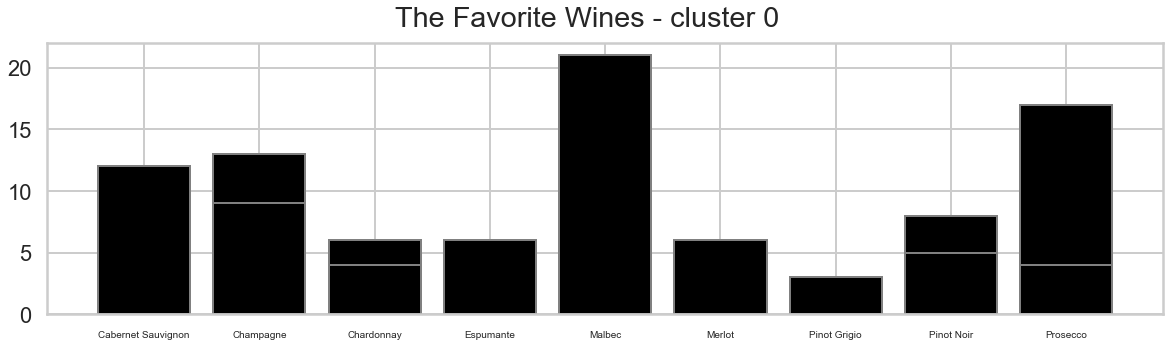

In [101]:
h0=plt.subplots(figsize=[20,5])
h0=plt.rc('xtick', labelsize=10) 
plt.suptitle('The Favorite Wines - cluster 0')
h0=plt.bar(zero_1.varietal.sort_values(), zero_1.cluster_id, color='black', edgecolor='grey')

plt.show()

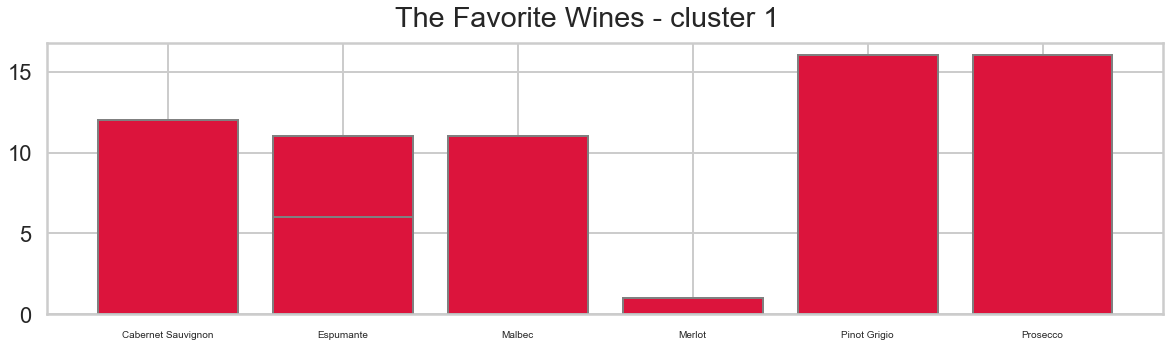

In [102]:
h1=plt.subplots(figsize=[20,5])
h1=plt.rc('xtick', labelsize=10) 
plt.suptitle('The Favorite Wines - cluster 1')
h1=plt.bar(one_1.varietal.sort_values(), one_1.cluster_id, color='crimson', edgecolor='grey')

plt.show()

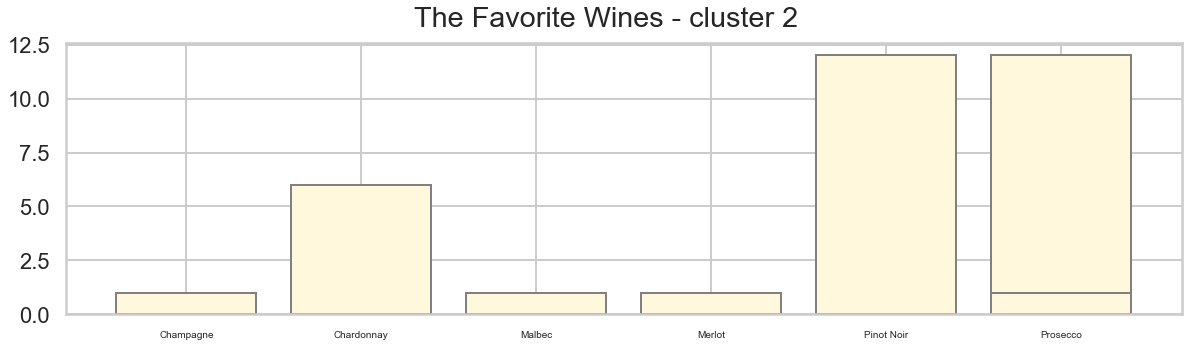

In [103]:
h2=plt.subplots(figsize=[20,5])
h2=plt.rc('xtick', labelsize=10) 
plt.suptitle('The Favorite Wines - cluster 2')
h2=plt.bar(two_1.varietal.sort_values(), two_1.cluster_id, color='cornsilk',  edgecolor='grey')
plt.show()

The customers from cluster 1 (crimson) are more into prosecco than champagne (which definetely shows questionable taste in sparkling wine) and bought mainly prosecco, cabernet, merlot and espumante. The customers from cluster 2 (cream) bought pinot noir, prosecco and chardonnay. Customers from cluster 0 (black), bought a little bit of everything with preferences for malbec and prosecco.

To conclude at this point:
- PCA split the customer data into three clusters. Cluster 0 (black) could use some refining.
- PCA highlighted purchase patterns for each cluster which depends on wine type, time of the year
- the influence of the discount rate and the minimun quantity should be investigated
- further investigation would help to taylor campaign type and timing to offer to the identified customer clusters.
- more investigation/modeling should be done on cluster 0.

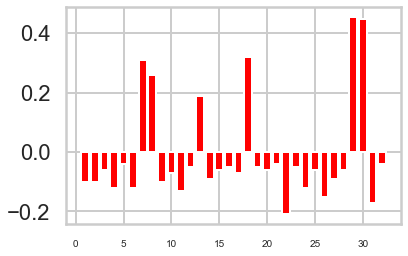

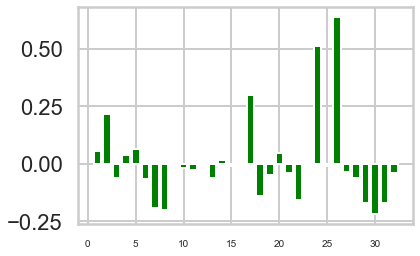

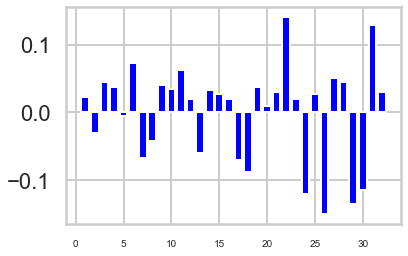

In [104]:
### copied from Tier 1
### to see the example given as solution

# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
k3_model= KMeans(n_clusters=3)
k3_clusters= k3_model.fit_predict(dfp3)

colors = ['red', 'green', 'blue']
offer_proportions = dfp3.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = dfp3[k3_clusters == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

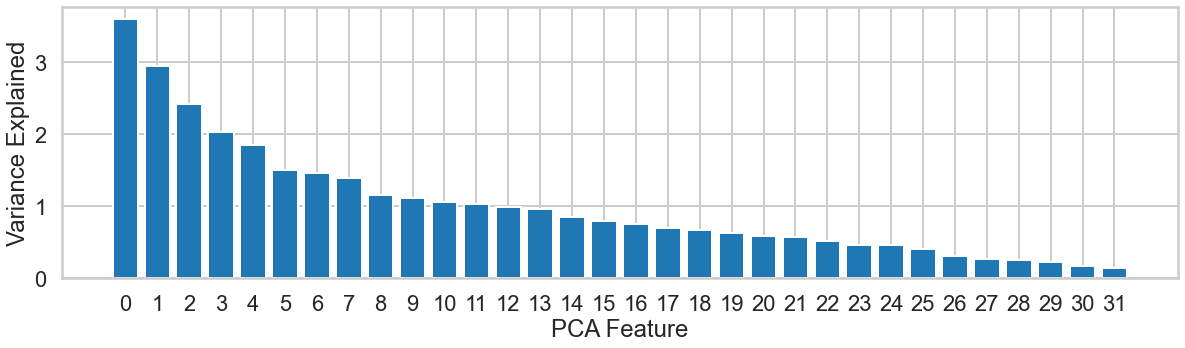

In [114]:
#your turn
# Initialize a new PCA model with a default number of components.

scaler=StandardScaler()
pca = PCA()
pipeline=make_pipeline(scaler,pca)
pipeline.fit(dfp3)
features=range(pca.n_components_)
plt.subplots(figsize=[20,5])
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('Variance Explained')
plt.xticks(features)
plt.show()

Text(0, 0.5, 'Variance Ratio')

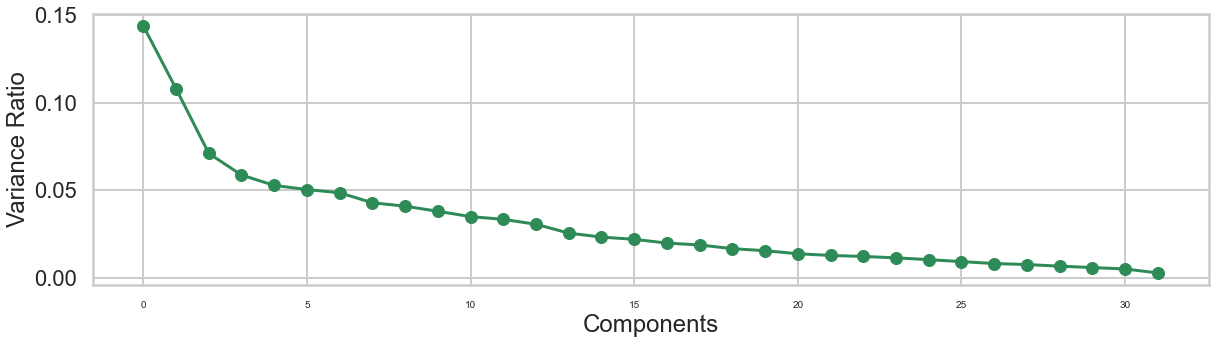

In [109]:
# Do the rest on your own :)
variance= pca.explained_variance_ratio_
h1=plt.subplots(figsize=[20,5])
plt.plot(range(len(variance)), variance, marker='o', color='seagreen')
#plt.xlim([0,30])
#plt.ylim([0,0.16])
plt.xlabel('Components')
plt.ylabel('Variance Ratio')

Looking at the PCA features on both the histogram and the scatter plot, not much variance is explained. Using the elbow method, it looks like the optimal number of components is 2 though it seems it does not explain much of the variance (0.12+0.07 ~20%).

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [121]:
#### Affinity Propagation
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

af=AffinityPropagation(random_state=5).fit(dfp3)
aflabels=af.labels_
af_pred=af.predict(dfp3)
af_cluster_centers=af.cluster_centers_
cluster_centers_indices = af.cluster_centers_indices_

In [ ]:
### Spectral Clustering

In [115]:
### Agglomerative Clustering

In [ ]:
### DBSCAN